# 准备工作

In [1]:
# 若要在binder中执行这个notebook，请先执行下面的指令来安装依赖包
# !pip install scikit-learn numpy pandas matplotlib

# 主动学习

何谓主动学习？这里我采用一种通俗的讲法：

想象你面对百万大军，要想打败他们未必需要将其全部剿灭，有时只需要斩其**上将**首级即可。

主动学习做的，就是帮助我们找到那个“上将”，解决重点问题，达到事半功倍的效果。看下面的图：

![Fig1](https://img-blog.csdnimg.cn/20181213203559446.jpg) 

左图中红绿代表两种数据。现在我们只能标注其中有限个数据来训练分类器。中间的图显示的就是随机标注的样本和得到的分界线，准确率大约为70%。而右图就是主动学习方法找到的标注点，因为这些点几乎构成了完美分界线的边界，所以使用与中图同样的样本数，它能够取得90%左右的准确率！

那么我们怎么找到这些关键的点呢？让我们从上例来考虑，上面找到的标注点都在中间区域，实际上都是相对比较**容易混淆的、难以确定类别的**样本。我们的目标就是找到这些样本。**分类器的预测概率**就可以帮助我们衡量这些特性，于是就有了下面的寻找策略：

- **RS策略**：随机选择，作为对照。
- **LC策略**：寻找分类器最没有信心的预测样本，即预测的最可能类别的概率也很低的样本。
- **BT策略**：寻找分类器最“左右为难”的预测样本，即预测的最可能的两个类别的概率很接近的样本。

下面用代码实验和验证这些策略的效果：

我们进行10批5个样本的标注，对于不同策略选出的样本，使用直接抽取已知标签的方法来模拟手动标注。来看看随着标注的进行，模型的表现如何改善，以及其最终的效果。


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
np.random.seed(1)               # reproduce the result
import warnings
warnings.filterwarnings("ignore")

In [11]:
batch_size = 10
rounds = 10

In [12]:
def RS(proba, batch_size):
    return np.random.choice(range(proba.shape[0]),batch_size,replace=False)

def LC(proba, batch_size):
    return np.argsort(np.max(proba,axis=1))[:batch_size]

def BT(proba, batch_size):
    sorted_proba = np.sort(proba,axis=1)
    return np.argsort(sorted_proba[:,-1]-sorted_proba[:,-2])[:batch_size]

In [13]:
strategies = {"RS":RS,"LC":LC,"BT":BT}
results = {"RS":[],"LC":[],"BT":[]}
for type0 in strategies:
    clf = LogisticRegression()
    anno_batch = RS(x,batch_size)    # 第一批标注样本只能随机选取
    x_train = x[anno_batch]
    y_train = y[anno_batch]
    for i in range(rounds-1):
        clf.fit(x_train,y_train)
        prec = clf.score(x,y)
        results[type0].append(prec)
        proba = clf.predict_proba(x)
        stategy0 = strategies[type0]      # 后面采用不同策略
        anno_batch = stategy0(proba,batch_size)
        x_train = np.concatenate([x_train,x[anno_batch]])
        y_train = np.concatenate([y_train,y[anno_batch]])
        
    prec = clf.score(x,y)
    results[type0].append(prec)

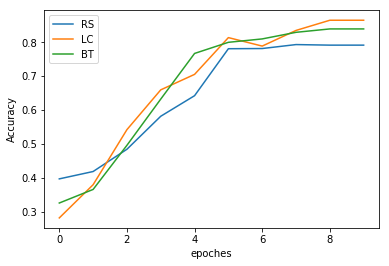

In [14]:
pd.DataFrame(results).plot()
plt.ylabel("Accuracy")
plt.xlabel("epoches")
plt.show()

以上只是一次随机实验的结果，会受每一批的具体样本影响而有一些波动。不过进行多次实验也可以看到，两种主动学习方法利用同样多的样本，却能够达到接近90%的准确率。确实比RS更胜一筹，我们可以使用这个技术来降低达到一定准确度所需的标注量。妈妈再也不用担心我手动标注数据的辛苦了！

# 体验手动标注

下面我也写了一段真正手动标注数据的代码，有兴趣的也不妨亲身尝试一下，用可以接受的时间量标注，打造出一个表现良好的模型：

In [15]:
from IPython import display
def human_annotate(batch_ids):
    ret = []
    plt.gray()
    for id0 in batch_ids:
        fig0 = plt.figure(figsize=(1,1)) 
        plt.matshow(digits.images[id0],fignum=0) 
        plt.show()
        ret.append(int(input("请输入这个样本的标签：")))
        display.clear_output(wait=True)      # 动态刷新输出
    return np.array(ret)

<Figure size 432x288 with 0 Axes>

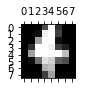

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [16]:
batch_size = 5
rounds = 3
results = []

clf = LogisticRegression()
anno_batch = RS(proba,batch_size)
x_train = x[anno_batch]
y_train = human_annotate(anno_batch)
for i in range(rounds-1):
    clf.fit(x_train,y_train)
    prec = clf.score(x,y)
    print(f"round {i}, prec:{prec}")
    results.append(prec)
    proba = clf.predict_proba(x)
    sorted_proba = np.sort(proba,axis=1)
    anno_batch = BT(proba,batch_size)
    x_train = np.concatenate([x_train,x[anno_batch]])
    y_train = np.concatenate([y_train,human_annotate(anno_batch)])
clf.fit(x_train,y_train)
prec = clf.score(x,y)
print(f"round {rounds}, prec:{prec}")
results.append(prec)
pd.Series(results).plot()
plt.ylabel("Accuracy")
plt.xlabel("human label round")
plt.show()

4